In [1]:
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common import results_plotter
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

In [2]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    import pandas as pd
    rolled = pd.Series(values).rolling(window)
    std = np.array(rolled.std())
    mean = np.array(rolled.mean())
    # weights = np.repeat(1.0, window) / window
    return mean, std#np.convolve(values, weights, "valid"), std


def plot_results(log_folder, 
                 title="Learning Curve", 
                 label = None,
                 window = 75,
                 ylim = None,
                 ):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y, std = moving_average(y, window=window)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    if label is None:
        label = 'mean rewards $\pm 2\sigma$'
    plt.plot(x, y, label=label)
    plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    if ylim is not None:
        plt.ylim(ylim)
    plt.title(title + " Smoothed")
    # plt.legend()
    # plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    return x
    # plt.show()

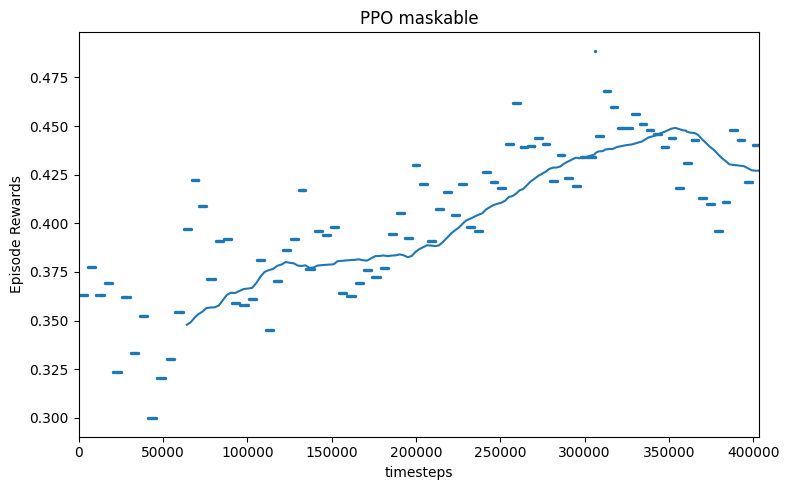

In [3]:
# log_dir = f'ppo_mask/rewardMode(normalized_terminal)_obsMode(elimination_gain)_steps(100000)'
# log_dir = f'ppo_mask/rewardMode(normalized_terminal)_obsMode(routes)_steps(500000)/'
# log_dir = f'ppo_mask/rewardMode(normalized_terminal)_obsMode(multi)_steps(400000)/'
# log_dir = f'ppo_mask/rewardMode(normalized_terminal)_obsMode(routes)_steps(100000)/'
log_dir = f'ppo_mask/rewardMode(normalized_terminal)_obsMode(routes)_steps(500000)_instanceID0/'

# log_dir = f'ppo_mask/rewardMode(normalized_terminal)_obsMode(routes)_steps(350000)/'
# log_dir = f'./'
# Helper from the library
results_plotter.plot_results(
    [log_dir], 5e5, results_plotter.X_TIMESTEPS, "PPO maskable", (8, 5)
)

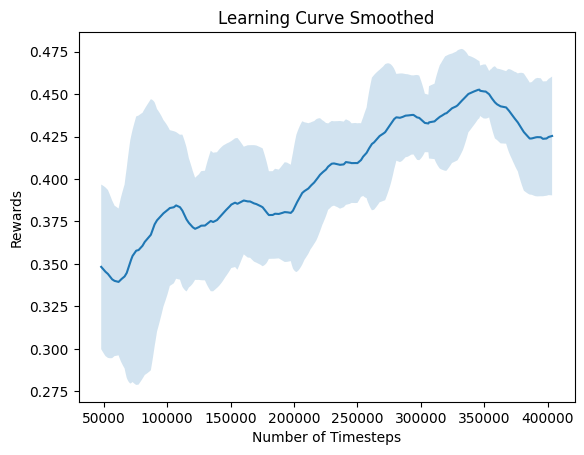

In [4]:
_ = plot_results(log_dir)
# _ = plot_results(log_dir2)

In [5]:
log_dir = f'ppo_mask/rewardMode(normalized_terminal)_obsMode(multi)_steps(200000)/'
log_dir2 = f'ppo_mask/rewardMode(normalized_terminal)_obsMode(routes)_steps(500000)/'
_ = plot_results(log_dir)
_ = plot_results(log_dir2)
plt.legend()

LoadMonitorResultsError: No monitor files of the form *monitor.csv found in ppo_mask/rewardMode(normalized_terminal)_obsMode(multi)_steps(200000)/

In [6]:
log_dir2 = f'ppo_mask/rewardMode(normalized_terminal)_obsMode(multi)_steps(150000)/'
_ = plot_results(log_dir2)
plt.legend()

LoadMonitorResultsError: No monitor files of the form *monitor.csv found in ppo_mask/rewardMode(normalized_terminal)_obsMode(multi)_steps(150000)/

In [7]:
from numba import njit
@njit
def get_solution_single_type(k):
    #get an optimal solution with k omitted packages from a full dynamic table
    solution = np.zeros(k, dtype=np.int64)


    return solution

get_solution_single_type(3)

array([0, 0, 0])

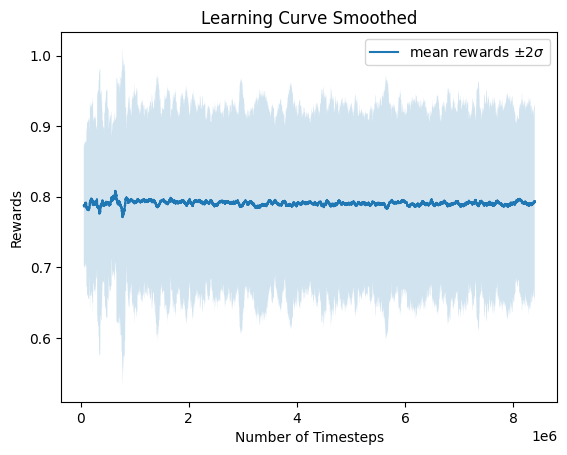

In [8]:
_ = plot_results('./', window=1000)
plt.legend()
plt.savefig('long_run')

In [7]:
# import torch
# from torch import nn

# m = nn.Sigmoid()
# loss = nn.BCELoss(reduction='sum')
# input = torch.randn(1, 5, requires_grad=True)
# target = torch.rand(1, 5, requires_grad=False)
# output = loss(m(input), target)
# print(m(input))
# print(target.nelement())
# print(output)
# print(nn.MSELoss(reduction='sum')(m(input), target))

In [8]:
K = 100
import sys
import os
from copy import deepcopy
# direc = os.path.dirname(__file__)
# pri&
# caution: path[0] is reserved for script path (or '' in REPL)
# print(str(path)+'/ppo')
sys.path.insert(1, '/Users/faridounet/PhD/TransportersDilemma')
from a_star import A_Star
from SA_baseline import recuit
from greedy_baseline import baseline
from assignment import RemoveActionEnv
import pickle
from shortcut import multi_types

with open(f'game_K{K}.pkl', 'rb') as f:
    g = pickle.load(f)
routes = np.load(f'routes_K{K}.npy')
dests = np.load(f'destinations_K{K}.npy')

env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
            #   obs_mode='action', 
            action_mode = 'destinations',
              change_instance = False, rewards_mode='normalized_terminal', instance_id = 0)
env.reset()
res_A = A_Star(deepcopy(env._env))#, max_time=120)
action_SA, *_ = recuit(deepcopy(env._env), 5000, 1,0.9999, H=100_000)
res_GTS = baseline(deepcopy(env._env))
i_id = 0
env.reset()
action_A = res_A['solution'].astype(int)
# a = dests[i_id][np.where(action_A == 0)].astype(int)
o, r_A, d, _, info = env.step(np.where(action_A == 0)[0])

env.reset()
# a = dests[i_id][np.where(action_SA == 0)].astype(int)
o, r_SA, d, _, info = env.step(np.where(action_SA == 0)[0])

a_GTS = res_GTS['solution']
env.reset()
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
o, r_GTS, d, _, info = env.step(np.where(a_GTS == 0)[0])


_, info = env.reset()
rtes = np.array([
    [
        env._env.initial_routes[m, i] 
        for i in range(0, len(env._env.initial_routes[m]), 2)
    ]
    for m in range(len(env._env.initial_routes))
], dtype=int)
# print(CM)
coeff = env._env._game.emissions_KM
CM = np.array([
    env._env.distance_matrix*coeff[i]
    for i in range(len(coeff))
]).copy()
a = multi_types(CM, rtes, coeff, info['excess_emission'])
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
print(a)
o, r_opt, d, _, info = env.step(a)

A* evaluated 3672 different assignments
m = 85168
11152.0


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function setitem>) found for signature:
 
 >>> setitem(array(float64, 2d, C), UniTuple(int64 x 2), array(float64, 1d, C))
 
There are 16 candidate implementations:
  - Of which 16 did not match due to:
  Overload of function 'setitem': File: <numerous>: Line N/A.
    With argument(s): '(array(float64, 2d, C), UniTuple(int64 x 2), array(float64, 1d, C))':
   No match.

During: typing of setitem at /Users/faridounet/PhD/TransportersDilemma/shortcut.py (41)

File "../shortcut.py", line 41:
def compute_delta(cost_matrix, route, k):
    <source elided>
                sum += cost_matrix[route[i-j-1], route[i-j]]
                delta[i, j] = sum - cost_matrix[route[i-j-1], current_vertex]
                ^

During: resolving callee type: type(CPUDispatcher(<function compute_delta at 0x293e2bc70>))
During: typing of call at /Users/faridounet/PhD/TransportersDilemma/shortcut.py (53)

During: resolving callee type: type(CPUDispatcher(<function compute_delta at 0x293e2bc70>))
During: typing of call at /Users/faridounet/PhD/TransportersDilemma/shortcut.py (53)

During: resolving callee type: type(CPUDispatcher(<function compute_delta at 0x293e2bc70>))
During: typing of call at /Users/faridounet/PhD/TransportersDilemma/shortcut.py (53)


File "../shortcut.py", line 53:
def compute_smallest_cost(cost_matrix, route, excess): 
    <source elided>
    K = len(route) - 1
    delta = compute_delta(cost_matrix, route, K+1)
    ^

During: resolving callee type: type(CPUDispatcher(<function compute_smallest_cost at 0x293e2beb0>))
During: typing of call at /Users/faridounet/PhD/TransportersDilemma/shortcut.py (169)

During: resolving callee type: type(CPUDispatcher(<function compute_smallest_cost at 0x293e2beb0>))
During: typing of call at /Users/faridounet/PhD/TransportersDilemma/shortcut.py (169)

During: resolving callee type: type(CPUDispatcher(<function compute_smallest_cost at 0x293e2beb0>))
During: typing of call at /Users/faridounet/PhD/TransportersDilemma/shortcut.py (169)


File "../shortcut.py", line 169:
def multi_types(cost_matrix, routes, coeff, excess):
    <source elided>
    for i in range(types):
        sol[i], values[i], max_omitted[i] = compute_smallest_cost(cost_matrix, routes[i], excess/(coeff[i]+1e-10))
        ^


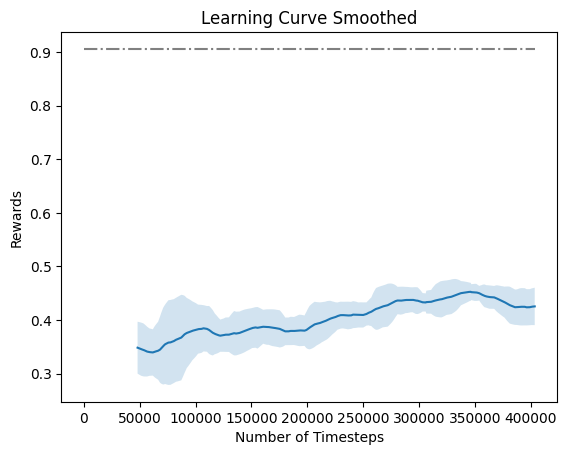

In [14]:
x = plot_results(log_dir, label='routes')#, show_hlines=True)
plt.hlines(r_opt, 0, x[-1], linestyles = '-.', label=f'A* = {round(r_opt, 4)}', colors='gray')

### K = 50

A* evaluated 495 different assignments
m = 85168
4104.0
trouve assez de packets avec le camion : 11 56.0
max ommited: [13 13 11 13]
solution de taille 11 [ 0  0 10  1] valeur 56.0
[ 8  0  4 19 43 31 25 11 33 36 34]


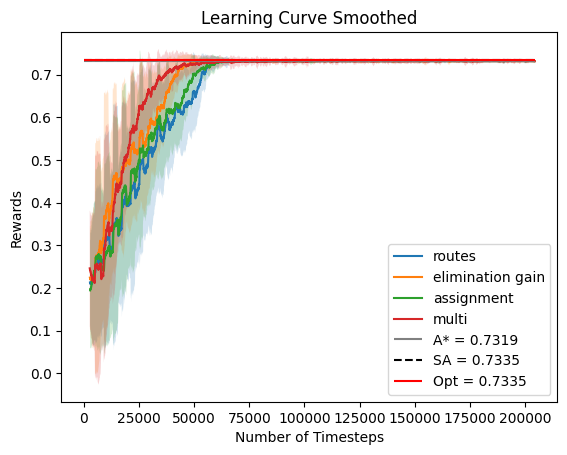

In [7]:
idx = 0
K = 50
steps = 200_000

import sys
import os
from copy import deepcopy
# direc = os.path.dirname(__file__)
# pri&
# caution: path[0] is reserved for script path (or '' in REPL)
# print(str(path)+'/ppo')
sys.path.insert(1, '/Users/faridounet/PhD/TransportersDilemma')
from a_star import A_Star
from SA_baseline import recuit
from greedy_baseline import baseline
from assignment import RemoveActionEnv
import pickle
from shortcut import multi_types
import numpy as np
import matplotlib.pyplot as plt

with open(f'game_K{K}.pkl', 'rb') as f:
    g = pickle.load(f)
routes = np.load(f'routes_K{K}.npy')
dests = np.load(f'destinations_K{K}.npy')

env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
            #   obs_mode='action', 
            action_mode = 'destinations',
              change_instance = False, rewards_mode='normalized_terminal', instance_id = 0)
env.reset()
res_A = A_Star(deepcopy(env._env))#, max_time=120)
action_SA, *_ = recuit(deepcopy(env._env), 5000, 1,0.9999, H=100_000)
res_GTS = baseline(deepcopy(env._env))
i_id = 0
env.reset()
action_A = res_A['solution'].astype(int)
# a = dests[i_id][np.where(action_A == 0)].astype(int)
o, r_A, d, _, info = env.step(np.where(action_A == 0)[0])

env.reset()
# a = dests[i_id][np.where(action_SA == 0)].astype(int)
o, r_SA, d, _, info = env.step(np.where(action_SA == 0)[0])

a_GTS = res_GTS['solution']
env.reset()
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
o, r_GTS, d, _, info = env.step(np.where(a_GTS == 0)[0])


_, info = env.reset()
rtes = np.array([
    [
        env._env.initial_routes[m, i] 
        for i in range(0, len(env._env.initial_routes[m]), 2)
    ]
    for m in range(len(env._env.initial_routes))
], dtype=int)
# print(CM)
coeff = env._env._game.emissions_KM
# CM = np.array([
#     env._env.distance_matrix*coeff[i]
#     for i in range(len(coeff))
# ]).copy()
a = multi_types(env._env.distance_matrix, rtes, coeff, info['excess_emission'])
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
print(a)
o, r_opt, d, _, info = env.step(a)

# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(cost_matrix)_steps(100000)_instanceID{idx}/', label='cost matrix (cnn)')#, show_hlines=True)
_ = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(routes)_steps(200000)_instanceID{idx}/', label='routes')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(action)_steps(200000)_instanceID{idx}/', label='action')#, show_hlines=True)
_ = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(elimination_gain)_steps(200000)_instanceID{idx}/', label='elimination gain')#, show_hlines=True)
_ = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(assignment)_steps(200000)_instanceID{idx}/', label='assignment')#, show_hlines=True)
x = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(multi)_steps(200000)_instanceID{idx}/', label='multi')#, show_hlines=True)

plt.hlines(r_A, 0, x[-1], label=f'A* = {round(r_A, 4)}', colors='gray')
# plt.hlines(r_GTS, 0, x[-1], linestyles = '--', label=f'GTS = {round(r_GTS, 4)}', colors='blue')
plt.hlines(r_SA, 0, x[-1], linestyles = '--', label=f'SA = {round(r_SA, 4)}', colors='black')
plt.hlines(r_opt, 0, x[-1], label=f'Opt = {round(r_opt, 4)}', colors='red')

plt.legend(loc='lower right')
plt.savefig('RL')
# plt.hlines(r_model, 0, x[-1], label='model', colors='red')
# plt.hlines((r_SA+1e5)/1e5, 0, x[-1], label='SA', colors='green')


### K = 100

In [8]:
idx = 0
K = 100
steps = 200_000

import sys
import os
from copy import deepcopy
# direc = os.path.dirname(__file__)
# pri&
# caution: path[0] is reserved for script path (or '' in REPL)
# print(str(path)+'/ppo')
sys.path.insert(1, '/Users/faridounet/PhD/TransportersDilemma')
from a_star import A_Star
from SA_baseline import recuit
from greedy_baseline import baseline
from assignment import RemoveActionEnv
import pickle
from shortcut import multi_types

with open(f'game_K{K}.pkl', 'rb') as f:
    g = pickle.load(f)
routes = np.load(f'routes_K{K}.npy')
dests = np.load(f'destinations_K{K}.npy')

env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
            #   obs_mode='action', 
            action_mode = 'destinations',
              change_instance = False, rewards_mode='normalized_terminal', instance_id = 0)
env.reset()
res_A = A_Star(deepcopy(env._env))#, max_time=120)
action_SA, *_ = recuit(deepcopy(env._env), 5000, 1,0.9999, H=100_000)
res_GTS = baseline(deepcopy(env._env))
i_id = 0
env.reset()
action_A = res_A['solution'].astype(int)
# a = dests[i_id][np.where(action_A == 0)].astype(int)
o, r_A, d, _, info = env.step(np.where(action_A == 0)[0])

env.reset()
# a = dests[i_id][np.where(action_SA == 0)].astype(int)
o, r_SA, d, _, info = env.step(np.where(action_SA == 0)[0])

a_GTS = res_GTS['solution']
env.reset()
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
o, r_GTS, d, _, info = env.step(np.where(a_GTS == 0)[0])


_, info = env.reset()
rtes = np.array([
    [
        env._env.initial_routes[m, i] 
        for i in range(0, len(env._env.initial_routes[m]), 2)
    ]
    for m in range(len(env._env.initial_routes))
], dtype=int)
# print(CM)
coeff = env._env._game.emissions_KM
# CM = np.array([
#     env._env.distance_matrix*coeff[i]
#     for i in range(len(coeff))
# ]).copy()
a = multi_types(env._env.distance_matrix, rtes, coeff, info['excess_emission'])
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
print(a)
o, r_opt, d, _, info = env.step(a)

A* evaluated 3672 different assignments
m = 85168
12604.0
max ommited: [25 25 25 25]
solution de taille 31 [ 0  2 23  6] valeur 117.0
[81  0 30 12 16 27 38 37 44 45 64 80 97 98 92 91 90 71 54 55 56 57 46 48
 61 96 89 79 95 99 94]


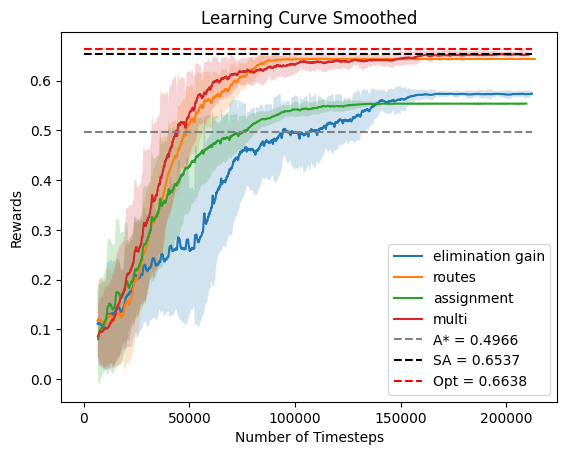

In [9]:


x = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(elimination_gain)_steps({steps})_instanceID{idx}/', label='elimination gain')#, show_hlines=True)
_ = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(routes)_steps({steps})_instanceID{idx}/', label='routes')#, show_hlines=True)
_ = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(assignment)_steps({steps})_instanceID{idx}/', label='assignment')#, show_hlines=True)
_ = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(multi)_steps({steps})_instanceID{idx}/', label='multi')#, show_hlines=True)

plt.hlines(r_A, 0, x[-1], linestyles = '--', label=f'A* = {round(r_A, 4)}', colors='gray')
# plt.hlines(r_GTS, 0, x[-1], linestyles = '--', label=f'GTS = {round(r_GTS, 4)}', colors='blue')
plt.hlines(r_SA, 0, x[-1], linestyles = '--', label=f'SA = {round(r_SA, 4)}', colors='black')
plt.hlines(r_opt, 0, x[-1],linestyles = '--', label=f'Opt = {round(r_opt, 4)}', colors='red')

plt.legend(loc='lower right')
plt.savefig('RL')
# plt.hlines(r_model, 0, x[-1], label='model', colors='red')
# plt.hlines((r_SA+1e5)/1e5, 0, x[-1], label='SA', colors='green')


### K = 1000

In [10]:
idx = 0
K = 1000
steps = 500_000

import sys
import os
from copy import deepcopy
# direc = os.path.dirname(__file__)
# pri&
# caution: path[0] is reserved for script path (or '' in REPL)
# print(str(path)+'/ppo')
sys.path.insert(1, '/Users/faridounet/PhD/TransportersDilemma')
from a_star import A_Star
from SA_baseline import recuit
from greedy_baseline import baseline
from assignment import RemoveActionEnv
import pickle
from shortcut import multi_types

with open(f'game_K{K}_retain0.0.pkl', 'rb') as f:
    g = pickle.load(f)
routes = np.load(f'routes_K{K}_retain0.0.npy')
dests = np.load(f'destinations_K{K}_retain0.0.npy')

env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
            #   obs_mode='action', 
            action_mode = 'destinations',
              change_instance = False, rewards_mode='normalized_terminal', instance_id = 0)
env.reset()
res_A = A_Star(deepcopy(env._env))#, max_time=120)
action_SA, *_ = recuit(deepcopy(env._env), 5000, 1,0.9999, H=100_000)
res_GTS = baseline(deepcopy(env._env))
i_id = 0
env.reset()
action_A = res_A['solution'].astype(int)
# a = dests[i_id][np.where(action_A == 0)].astype(int)
o, r_A, d, _, info = env.step(np.where(action_A == 0)[0])

env.reset()
# a = dests[i_id][np.where(action_SA == 0)].astype(int)
o, r_SA, d, _, info = env.step(np.where(action_SA == 0)[0])

a_GTS = res_GTS['solution']
env.reset()
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
o, r_GTS, d, _, info = env.step(np.where(a_GTS == 0)[0])


_, info = env.reset()
rtes = np.array([
    [
        env._env.initial_routes[m, i] 
        for i in range(0, len(env._env.initial_routes[m]), 2)
    ]
    for m in range(len(env._env.initial_routes))
], dtype=int)
# print(CM)
coeff = env._env._game.emissions_KM
# CM = np.array([
#     env._env.distance_matrix*coeff[i]
#     for i in range(len(coeff))
# ]).copy()
a = multi_types(env._env.distance_matrix, rtes, coeff, info['excess_emission'])
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
print(a)
o, r_opt, d, _, info = env.step(a)

A* evaluated 98644 different assignments
m = 85168
20848.0
trouve assez de packets avec le camion : 92 240.0
trouve assez de packets avec le camion : 109 239.0
max ommited: [200 200 200  92 109]
solution de taille 82 [ 0  1  0 30 51] valeur 243.0
[481 307 569 568 510 909 964 965 997 996 998 969 934 933 854 907 906 931
 960 961 962 957 958 959 956 815 502 501 472 471 470 860 890 913 911 806
 537 567 566 622 649 592 563 562 591 619 618 646 645 672 673 703 704 705
 733 764 797 824 825 826 799 766 765 763 796 795 762 761 732 731 760 793
 822 848 847 821 820 791 790 757 758 759]


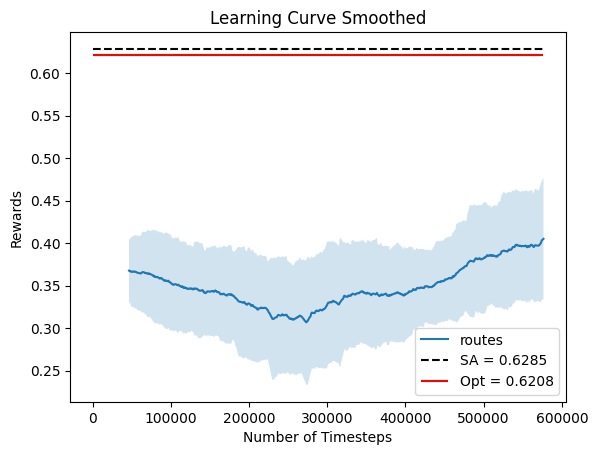

In [23]:
idx = 0
K = 1000
steps = 500_000

# x = plot_results(log_dir, label='routes')#, show_hlines=True)
x = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(routes)_steps({steps})_instanceID{idx}/', label='routes')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(cost_matrix)_steps(100000)_instanceID{idx}/', label='cost matrix (cnn)')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(routes)_steps(100000)_instanceID{idx}/', label='routes')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(action)_steps(100000)_instanceID{idx}/', label='action')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(elimination_gain)_steps(100000)_instanceID{idx}/', label='elimination gain')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(assignment)_steps(100000)_instanceID{idx}/', label='assignment')#, show_hlines=True)
# x = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(multi)_steps(100000)_instanceID{idx}/', label='multi')#, show_hlines=True)

# plt.hlines(r_A, 0, x[-1], label=f'A* = {round(r_A, 4)}', colors='gray')
# plt.hlines(r_GTS, 0, x[-1], linestyles = '--', label=f'GTS = {round(r_GTS, 4)}', colors='blue')
plt.hlines(r_SA, 0, x[-1], linestyles = '--', label=f'SA = {round(r_SA, 4)}', colors='black')
plt.hlines(r_opt, 0, x[-1], label=f'Opt = {round(r_opt, 4)}', colors='red')

plt.legend(loc='lower right')
plt.savefig('RL')
# plt.hlines(r_model, 0, x[-1], label='model', colors='red')
# plt.hlines((r_SA+1e5)/1e5, 0, x[-1], label='SA', colors='green')


### K = 250

In [19]:
idx = 0
K = 250
steps = 500_000

import sys
import os
from copy import deepcopy
# direc = os.path.dirname(__file__)
# pri&
# caution: path[0] is reserved for script path (or '' in REPL)
# print(str(path)+'/ppo')
sys.path.insert(1, '/Users/faridounet/PhD/TransportersDilemma')
from a_star import A_Star
from SA_baseline import recuit
from greedy_baseline import baseline
from assignment import RemoveActionEnv
import pickle
from shortcut import multi_types

with open(f'game_K{K}.pkl', 'rb') as f:
    g = pickle.load(f)
routes = np.load(f'routes_K{K}.npy')
dests = np.load(f'destinations_K{K}.npy')

env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
            #   obs_mode='action', 
            action_mode = 'destinations',
              change_instance = False, rewards_mode='normalized_terminal', instance_id = 0)
env.reset()
# res_A = A_Star(deepcopy(env._env))#, max_time=120)
action_SA, *_ = recuit(deepcopy(env._env), 5000, 1,0.9999, H=100_000)
res_GTS = baseline(deepcopy(env._env))
i_id = 0
env.reset()
# action_A = res_A['solution'].astype(int)
# a = dests[i_id][np.where(action_A == 0)].astype(int)
# o, r_A, d, _, info = env.step(np.where(action_A == 0)[0])

env.reset()
# a = dests[i_id][np.where(action_SA == 0)].astype(int)
o, r_SA, d, _, info = env.step(np.where(action_SA == 0)[0])

a_GTS = res_GTS['solution']
env.reset()
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
o, r_GTS, d, _, info = env.step(np.where(a_GTS == 0)[0])


_, info = env.reset()
rtes = np.array([
    [
        env._env.initial_routes[m, i] 
        for i in range(0, len(env._env.initial_routes[m]), 2)
    ]
    for m in range(len(env._env.initial_routes))
], dtype=int)
# print(CM)
coeff = env._env._game.emissions_KM
# CM = np.array([
#     env._env.distance_matrix*coeff[i]
#     for i in range(len(coeff))
# ]).copy()
a = multi_types(env._env.distance_matrix, rtes, coeff, info['excess_emission'])
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
print(a)
o, r_opt, d, _, info = env.step(a)

m = 85168
10308.0
max ommited: [50 50 50 50 50]
solution de taille 90 [ 0  1  1 49 39] valeur 261.0
[ 42  78 111 126 136 150 160 177 176 175 191 192 193 194 178 179 195 215
 214 204 213 225 239 240 226 241 242 227 228 229 216 217 230 243 218 219
 231 244 245 246 233 232 220 209 221 234 247 248 235 236 223  67  80  95
  81  82  70  68  69  56  57  71  72  58  45  34  33  32  20  21   9   8
   7   6  19  18   5   4   3  17  28  27  26  25  15   2   1   0  14  39]


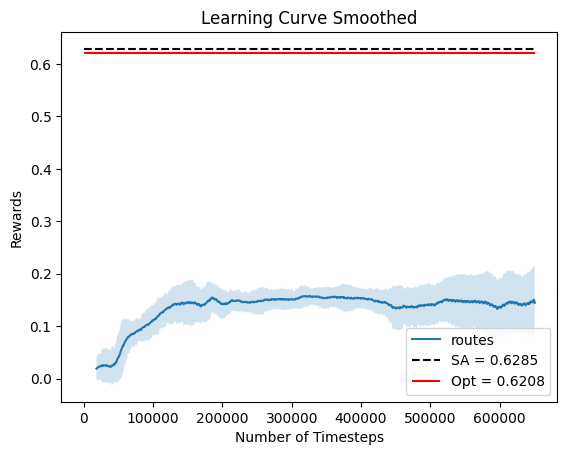

In [20]:
idx = 0
steps = 500_000

# x = plot_results(log_dir, label='routes')#, show_hlines=True)
x = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(routes)_steps({steps})_instanceID{idx}/', label='routes')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(cost_matrix)_steps(100000)_instanceID{idx}/', label='cost matrix (cnn)')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(routes)_steps(100000)_instanceID{idx}/', label='routes')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(action)_steps(100000)_instanceID{idx}/', label='action')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(elimination_gain)_steps(100000)_instanceID{idx}/', label='elimination gain')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(assignment)_steps(100000)_instanceID{idx}/', label='assignment')#, show_hlines=True)
# x = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(multi)_steps(100000)_instanceID{idx}/', label='multi')#, show_hlines=True)

# plt.hlines(r_A, 0, x[-1], label=f'A* = {round(r_A, 4)}', colors='gray')
# plt.hlines(r_GTS, 0, x[-1], linestyles = '--', label=f'GTS = {round(r_GTS, 4)}', colors='blue')
plt.hlines(r_SA, 0, x[-1], linestyles = '--', label=f'SA = {round(r_SA, 4)}', colors='black')
plt.hlines(r_opt, 0, x[-1], label=f'Opt = {round(r_opt, 4)}', colors='red')

plt.legend(loc='lower right')
plt.savefig('RL')
# plt.hlines(r_model, 0, x[-1], label='model', colors='red')
# plt.hlines((r_SA+1e5)/1e5, 0, x[-1], label='SA', colors='green')


### K = 400

In [ ]:
idx = 0
K = 400
steps = 500_000

import sys
import os
from copy import deepcopy
# direc = os.path.dirname(__file__)
# pri&
# caution: path[0] is reserved for script path (or '' in REPL)
# print(str(path)+'/ppo')
sys.path.insert(1, '/Users/faridounet/PhD/TransportersDilemma')
from a_star import A_Star
from SA_baseline import recuit
from greedy_baseline import baseline
from assignment import RemoveActionEnv
import pickle
from shortcut import multi_types

with open(f'game_K{K}.pkl', 'rb') as f:
    g = pickle.load(f)
routes = np.load(f'routes_K{K}.npy')
dests = np.load(f'destinations_K{K}.npy')

env = RemoveActionEnv(game = g, saved_routes = routes, saved_dests=dests, 
            #   obs_mode='action', 
            action_mode = 'destinations',
              change_instance = False, rewards_mode='normalized_terminal', instance_id = 0)
env.reset()
# res_A = A_Star(deepcopy(env._env))#, max_time=120)
action_SA, *_ = recuit(deepcopy(env._env), 5000, 1,0.9999, H=100_000)
res_GTS = baseline(deepcopy(env._env))
i_id = 0
env.reset()
# action_A = res_A['solution'].astype(int)
# a = dests[i_id][np.where(action_A == 0)].astype(int)
# o, r_A, d, _, info = env.step(np.where(action_A == 0)[0])

env.reset()
# a = dests[i_id][np.where(action_SA == 0)].astype(int)
o, r_SA, d, _, info = env.step(np.where(action_SA == 0)[0])

a_GTS = res_GTS['solution']
env.reset()
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
o, r_GTS, d, _, info = env.step(np.where(a_GTS == 0)[0])


_, info = env.reset()
rtes = np.array([
    [
        env._env.initial_routes[m, i] 
        for i in range(0, len(env._env.initial_routes[m]), 2)
    ]
    for m in range(len(env._env.initial_routes))
], dtype=int)
# print(CM)
coeff = env._env._game.emissions_KM
# CM = np.array([
#     env._env.distance_matrix*coeff[i]
#     for i in range(len(coeff))
# ]).copy()
a = multi_types(env._env.distance_matrix, rtes, coeff, info['excess_emission'])
# a = dests[i_id][np.where(a_GTS == 0)].astype(int)
print(a)
o, r_opt, d, _, info = env.step(a)

In [ ]:
idx = 0
steps = 500_000

# x = plot_results(log_dir, label='routes')#, show_hlines=True)
x = plot_results(f'ppo_mask/K{K}_rewardMode(normalized_terminal)_obsMode(routes)_steps({steps})_instanceID{idx}/', label='routes')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(cost_matrix)_steps(100000)_instanceID{idx}/', label='cost matrix (cnn)')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(routes)_steps(100000)_instanceID{idx}/', label='routes')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(action)_steps(100000)_instanceID{idx}/', label='action')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(elimination_gain)_steps(100000)_instanceID{idx}/', label='elimination gain')#, show_hlines=True)
# _ = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(assignment)_steps(100000)_instanceID{idx}/', label='assignment')#, show_hlines=True)
# x = plot_results(f'ppo_mask/rewardMode(normalized_terminal)_obsMode(multi)_steps(100000)_instanceID{idx}/', label='multi')#, show_hlines=True)

# plt.hlines(r_A, 0, x[-1], label=f'A* = {round(r_A, 4)}', colors='gray')
# plt.hlines(r_GTS, 0, x[-1], linestyles = '--', label=f'GTS = {round(r_GTS, 4)}', colors='blue')
plt.hlines(r_SA, 0, x[-1], linestyles = '--', label=f'SA = {round(r_SA, 4)}', colors='black')
plt.hlines(r_opt, 0, x[-1], label=f'Opt = {round(r_opt, 4)}', colors='red')

plt.legend(loc='lower right')
plt.savefig('RL')
# plt.hlines(r_model, 0, x[-1], label='model', colors='red')
# plt.hlines((r_SA+1e5)/1e5, 0, x[-1], label='SA', colors='green')


### Others

In [67]:
# log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(50000)/'
# x, y = ts2xy(load_results(log_folder), "timesteps")
# y, std = moving_average(y, window=50)
# # Truncate x
# x = x[len(x) - len(y) :]
# fig = plt.figure('title')
# plt.plot(x, y, label='v0 : [2048, 2048, 1024, 256]')
# plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2)

# log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(51200)/'
# x, y = ts2xy(load_results(log_folder), "timesteps")
# y, std = moving_average(y, window=50)
# # Truncate x
# x = x[len(x) - len(y) :]
# fig = plt.figure('title')
# plt.plot(x, y, label='v1 : [2048, 2048, 1024]')
# plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2)

# log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(51000)/'
# x, y = ts2xy(load_results(log_folder), "timesteps")
# y, std = moving_average(y, window=50)
# # Truncate x
# x = x[len(x) - len(y) :]
# fig = plt.figure('title')
# plt.plot(x, y, label='v2 : [1024, 1024, 256, 128]')
# plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2)

# log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(51250)/'
# x, y = ts2xy(load_results(log_folder), "timesteps")
# y, std = moving_average(y, window=50)
# # Truncate x
# x = x[len(x) - len(y) :]
# fig = plt.figure('title')
# plt.plot(x, y, label='v3 : [1024, 1024, 256, 128]', color='red')
# plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2)

# plt.legend()

LoadMonitorResultsError: No monitor files of the form *monitor.csv found in ppo_mask/rewardMode(normalized_terminal)_steps(50000)/

In [ ]:
# log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(50002)_instanceID0/'
# x, y = ts2xy(load_results(log_folder), "timesteps")
# y, std = moving_average(y, window=50)
# # Truncate x
# col = 'red'
# x = x[len(x) - len(y) :]
# fig = plt.figure('title')
# plt.plot(x, y, label='obs action', color=col)
# plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2, color = col)


# log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(50001)_instanceID0/'
# x, y = ts2xy(load_results(log_folder), "timesteps")
# y, std = moving_average(y, window=50)
# col = 'green'
# # Truncate x
# x = x[len(x) - len(y) :]
# fig = plt.figure('title')
# plt.plot(x, y, label='obs normalized routes', color=col)
# plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2, color = col)


# log_folder = 'ppo_mask/rewardMode(normalized_terminal)_steps(50003)_instanceID0/'
# x, y = ts2xy(load_results(log_folder), "timesteps")
# y, std = moving_average(y, window=50)
# col = 'purple'
# # Truncate x
# x = x[len(x) - len(y) :]
# fig = plt.figure('title')
# plt.plot(x, y, label='obs routes', color=col)
# plt.fill_between(x, y - 2*std, y + 2*std, alpha=0.2, color = col)

# plt.legend()